Name:Endal Rishika




Student Id :1002031323

https://www.kaggle.com/datasets/samaneheslamifar/facial-emotion-expressions

https://www.analyticsvidhya.com/blog/2022/01/introduction-to-neural-networks/#:~:text=What%20are%20Neural%20Networks%3F,quickly%20and%20its%20fast%20responses. https://www.sciencedirect.com/science/article/abs/pii/S0149763421002335#:~:text=Brain%20organizations%20of%20facial%20expression%20recognition%20support%20the%20constructionist%20hypothesis.&text=Common%20brain%20activation%20and%20connectivity,different%20discrete%2Fdimensional%20facial%20expressions.&text=The%20amygdala%2Dcentered%20'core',are%20connected%20to%20distributed%20networks.

https://aws.amazon.com/what-is/overfitting/#:~:text=Overfitting%20is%20an%20undesirable%20machine,on%20a%20known%20data%20set.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

source: https://www.kaggle.com/datasets/samaneheslamifar/facial-emotion-expressions

In [3]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import cv2

tf.random.set_seed(23)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_dir = '/content/drive/MyDrive/images'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['.DS_Store', 'LabelEncoder.pck', 'notebook82c363761d.ipynb', 'images', '.ipynb_checkpoints', 'validation', 'train']
Train Classes - ['disgust', 'fear', 'angry', 'happy', 'neutral', 'surprise', 'sad']
Validation Classes - ['surprise', 'neutral', 'angry', 'sad', 'happy', 'disgust', 'fear']


In [6]:
# Creating the Pathlib PATH objects
train_path = Path("/kaggle/input/facial-emotion-expressions/images/train")
valid_path = Path("/kaggle/input/facial-emotion-expressions/images/validation")

Define constants

In [7]:
batch_size = 64
epochs = 40
img_channel = 3
img_width, img_height = (48,48)
train_dataset_main = data_dir + "/train"
valid_dataset_main = data_dir + "/validation"

Prepare datasets


In [8]:
def create_dataset_df(main_path, dataset_name):
    print(f"{dataset_name} is creating ...")
    df = {"img_path":[],"class_names":[]}
    for class_names in os.listdir(main_path):
            for img_path in glob.glob(f"{main_path}/{class_names}/*"):
                df["img_path"].append(img_path)
                df["class_names"].append(class_names)
    df = pd.DataFrame(df)
    print(f"{dataset_name} is created !")
    return df

In [9]:
train_df = create_dataset_df(train_dataset_main, "Train dataset")

Train dataset is creating ...
Train dataset is created !


In [10]:
valid_df=create_dataset_df(valid_dataset_main, "Validation dataset")

Validation dataset is creating ...
Validation dataset is created !


In [11]:
train_df.sample(5)

,img_path,class_names
27243,/content/drive/MyDrive/images/train/sad/13525.jpg,sad
8260,/content/drive/MyDrive/images/train/angry/1944...,angry
18242,/content/drive/MyDrive/images/train/neutral/26...,neutral
21205,/content/drive/MyDrive/images/train/surprise/7...,surprise
989,/content/drive/MyDrive/images/train/fear/847.jpg,fear


In [12]:
valid_df.sample(5)

,img_path,class_names
2895,/content/drive/MyDrive/images/validation/angry...,angry
3624,/content/drive/MyDrive/images/validation/sad/2...,sad
1206,/content/drive/MyDrive/images/validation/neutr...,neutral
6960,/content/drive/MyDrive/images/validation/fear/...,fear
5036,/content/drive/MyDrive/images/validation/happy...,happy


In [13]:
print(f"train samples: {len(train_df)} \n validation samples: {len(valid_df)}")

train samples: 28851 
 validation samples: 7066


Visualization

In [14]:
def vizualizing_images(df,n_rows,n_cols):
    plt.figure(figsize=(10,10))
    for i in range(n_rows*n_cols):
        index = np.random.randint(0, len(df))
        img = cv2.imread(df.img_path[index])
        class_nm = df.class_names[index]
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img)
        plt.title(class_nm)
    plt.show()

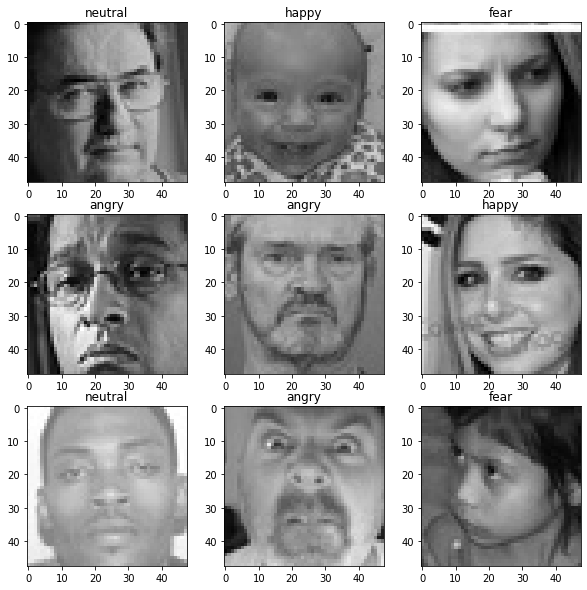

In [15]:
vizualizing_images(train_df, 3, 3)

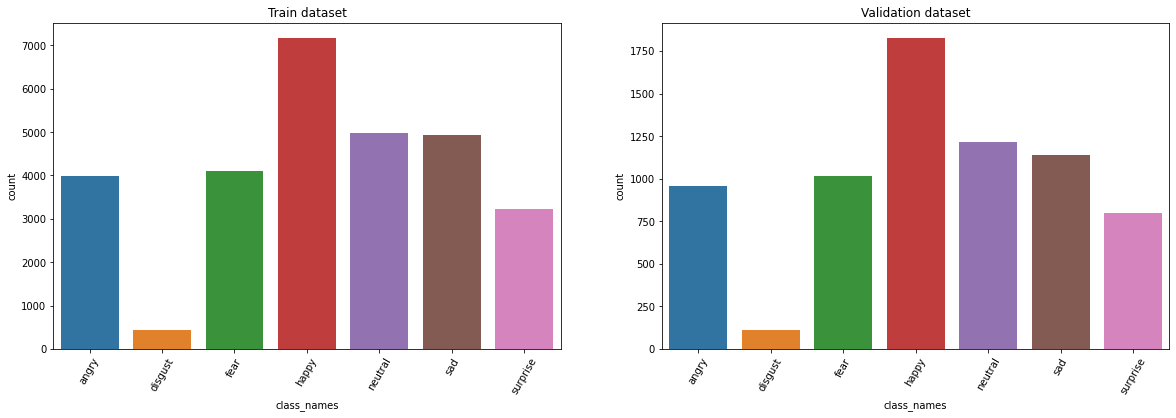

In [16]:
plt.figure(figsize=(20,6))
# train dataset
plt.subplot(1,2,1)
sns.countplot(data=train_df.sort_values("class_names"),x="class_names")
plt.title("Train dataset")
plt.xticks(rotation = 60)
# validation dataset
plt.subplot(1,2,2)
sns.countplot(data=valid_df.sort_values("class_names"),x="class_names")
plt.title("Validation dataset")
plt.xticks(rotation = 60)

plt.show()

In [17]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_df["class_names"] = Le.fit_transform(train_df["class_names"])

train_df["class_names"].value_counts()

3    7164
4    4982
5    4938
2    4113
0    3993
6    3225
1     436
Name: class_names, dtype: int64

In [18]:
valid_df["class_names"] = Le.transform(valid_df["class_names"])

In [19]:
#One Hot encoding
train_labels = tf.keras.utils.to_categorical(train_df["class_names"])
valid_labels = tf.keras.utils.to_categorical(valid_df["class_names"])


In [20]:
train_labels[:10]

array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [21]:
train_labels.sum(axis=0)

array([3993.,  436., 4113., 7164., 4982., 4938., 3225.], dtype=float32)

In [22]:
# Compute class weights 

classTotals = train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.7941397, 1: 16.431192, 2: 1.7417943, 3: 1.0, 4: 1.4379767, 5: 1.4507898, 6: 2.2213953}


In [23]:
input_image = cv2.imread(train_df.img_path[0])

input_image.shape

(48, 48, 3)

In [24]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [25]:
IMG_SIZE = 128 # increase image size 
BATCH_SIZE = 128 # increase batch size for faster training

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),    # add vertical flip for more variation
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),                       # increase range of rotation
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2),                # add contrast adjustment
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.2, -0.1))    # increase range of zoom
])

In [26]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE #to find a good allocation of its CPU budget across all parameters
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
        dataset = dataset.repeat()
    
    return dataset

In [27]:
# Creating Train Dataset object and Verifying it
%time 
train_dataset = get_dataset(train_df["img_path"], train_labels)

#iter() returns an iterator of the given object
#next() returns the next number in an iterator
image , label = next(iter(train_dataset)) 
print(image.shape)
print(label.shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10 µs


(128, 128, 128, 3)
(128, 7)


disgust


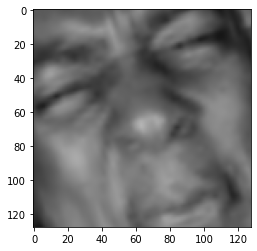

In [28]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(128 , 128 , 3))

In [29]:
%time 
val_dataset = get_dataset(valid_df["img_path"] , valid_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs
(128, 128, 128, 3)
(128, 7)


surprise


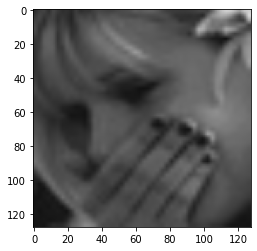

In [30]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(128 , 128 , 3))

In [31]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(128, 128, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 4, 4, 1408)       7768569   
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 128)         1622144   
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          73792     
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                      

In [32]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [33]:
len(train_labels),len(valid_labels)

(28851, 7066)

In [34]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=2,mode="auto")

In [35]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_labels)//BATCH_SIZE,
    epochs=12,
    callbacks=[early_stopping],
    validation_data=val_dataset,
    validation_steps = len(valid_labels)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12
225/225 [==============================] - 5707s 25s/step - loss: 3.0176 - accuracy: 0.3733 - precision: 0.5975 - recall: 0.1857 - val_loss: 2.6727 - val_accuracy: 0.1615 - val_precision: 0.1471 - val_recall: 0.0851
Epoch 2/12
  6/225 [..............................] - ETA: 1:21:52 - loss: 21.5064 - accuracy: 0.0695 - precision: 0.0817 - recall: 0.0535

KeyboardInterrupt: ignored

In [ ]:
model.layers[0].trainable = False

In [ ]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=2)

In [ ]:
model.summary()

In [ ]:
# 2nd Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_labels)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(valid_labels)//BATCH_SIZE,
    class_weight=class_weight
)

Save Objects

In [ ]:
# Save Model
model.save("FacialExpressionModel.h5")

In [ ]:
# Save Label Encoder 
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [ ]:
save_object(Le, "LabelEncoder")

Real-World Test on Jupyter Notebook